In [31]:
from pygmsh.built_in.geometry import Geometry

In [2]:
geom = Geometry()

In [3]:
mesh_ele_size = .25
p0 = geom.add_point([0, 0, 0], lcar=mesh_ele_size)
p1 = geom.add_point([1, 0, 0], lcar=mesh_ele_size)
p2 = geom.add_point([1, 1, 0], lcar=mesh_ele_size)
p3 = geom.add_point([0, 1, 0], lcar=mesh_ele_size)

l0 = geom.add_line(p0, p1)
l1 = geom.add_line(p1, p2)
l2 = geom.add_line(p2, p3)
l3 = geom.add_line(p3, p0)

ll = geom.add_line_loop(lines=[l0, l1, l2, l3])
ps = geom.add_plane_surface(ll)

In [4]:
# Tag line and surface
geom.add_physical(l3, label=444)
geom.add_physical(ps, label=456)

In [5]:
#print("\n".join(geom._GMSH_CODE))

In [6]:
from pygmsh import generate_mesh
mesh = generate_mesh(geom)

Info    : Running 'gmsh -3 /tmp/tmpx_kh1dgt.geo -format msh -bin -o /tmp/tmpakzzfzel.msh' [Gmsh 4.2.2, 1 node, max. 1 thread]
Info    : Started on Thu Jun 27 05:56:47 2019
Info    : Reading '/tmp/tmpx_kh1dgt.geo'...
Info    : Done reading '/tmp/tmpx_kh1dgt.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Done meshing 1D (0 s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Delaunay)
Info    : Done meshing 2D (0 s)
Info    : Meshing 3D...
Info    : Done meshing 3D (0 s)
Info    : 29 vertices 60 elements
Info    : Writing '/tmp/tmpakzzfzel.msh'...
Info    : Done writing '/tmp/tmpakzzfzel.msh'
Info    : Stopped on Thu Jun 27 05:56:47 2019


# Step 2: Mesh conversion with meshio to XDMF

In [7]:
import meshio

In [8]:
points, cells, cell_data = mesh.points, mesh.cells, mesh.cell_data

In [9]:
meshio.write("mesh_2d.xdmf", meshio.Mesh(
    points=points,
    cells={"triangle": cells["triangle"]}))

In [10]:
meshio.write("mvc_1d.xdmf", meshio.Mesh(
    points=points,
    cells={"line": cells["line"]},
    cell_data={"line": {"name_to_read": cell_data["line"]["gmsh:physical"]}}
))

# Step 3: Reading mesh in dolfinx

In [11]:
import dolfin
import dolfin.io
import numpy

In [12]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world,"mesh_2d.xdmf") as xdmf_infile:
    mesh_2d = xdmf_infile.read_mesh(dolfin.MPI.comm_world, dolfin.cpp.mesh.GhostMode.none)

In [13]:
import dolfin.plotting as plt
%matplotlib inline

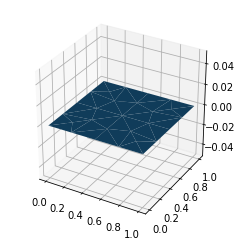

In [14]:
plt.plot(mesh_2d)

In [15]:
cells['line']

array([[ 3, 13],
       [13, 14],
       [14, 15],
       [15,  0]])

In [16]:
points

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.25      ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.75      ,  0.        ,  0.        ],
       [ 1.        ,  0.25      ,  0.        ],
       [ 1.        ,  0.5       ,  0.        ],
       [ 1.        ,  0.75      ,  0.        ],
       [ 0.75      ,  1.        ,  0.        ],
       [ 0.5       ,  1.        ,  0.        ],
       [ 0.25      ,  1.        ,  0.        ],
       [ 0.        ,  0.75      ,  0.        ],
       [ 0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.25      ,  0.        ],
       [ 0.5       ,  0.5       ,  0.        ],
       [ 0.70833333,  0.70833333,  0.        ],
       [ 0.29166667,  0.70833333,  0.        ],
       [ 0.70833333,  0.29166667,  0.        ],
       [ 0.29166667,  0.29166667,  0.   

In [17]:
map_gmsh_dolfin={}

In [18]:
for pt in numpy.unique(cells['line']):
    for ve in dolfin.Vertices(mesh_2d):
        if (ve.point() == points[pt]).all():
            map_gmsh_dolfin[pt] = ve.entities(0)[0]
            print(pt," : ",ve.entities(0),":",ve.point())

0  :  [27] : [ 0.  0.  0.]
3  :  [26] : [ 0.  1.  0.]
13  :  [4] : [ 0.    0.75  0.  ]
14  :  [17] : [ 0.   0.5  0. ]
15  :  [15] : [ 0.    0.25  0.  ]


In [19]:
map_gmsh_dolfin

{0: 27, 3: 26, 13: 4, 14: 17, 15: 15}

In [20]:
from dolfin import *

In [21]:
edges=dolfin.MeshEntities(mesh_2d,1)

In [33]:
for edge in edges:
    st = ""
    for vtx in VertexRange(edge):
        st = st +" "+ str(vtx.global_index())
    print(edge.global_index(), st)

0  17 10
1  17 21
2  17 23
3  9 17
4  16 17
5  17 25
6  10 21
7  10 11
8  10 25
9  2 10
10  18 21
11  12 21
12  11 21
13  16 21
14  18 13
15  18 22
16  12 18
17  18 16
18  18 26
19  13 22
20  13 14
21  13 26
22  3 13
23  20 22
24  15 22
25  14 22
26  16 22
27  19 7
28  19 23
29  19 24
30  6 19
31  16 19
32  19 27
33  7 23
34  7 8
35  7 27
36  1 7
37  9 23
38  8 23
39  16 23
40  20 4
41  20 24
42  15 20
43  20 16
44  20 28
45  4 24
46  4 5
47  4 28
48  0 4
49  6 24
50  5 24
51  16 24
52  8 9
53  9 25
54  9 2
55  5 6
56  6 27
57  6 1
58  11 12
59  12 26
60  12 3
61  14 15
62  15 28
63  15 0
64  2 25
65  3 26
66  1 27
67  0 28


In [23]:
edge_table=[]
for edge in edges:
    print(edge.global_index(),"  ",edge.entities(0)[0],"",edge.entities(0)[1]) 

0    0  1
1    0  2
2    0  8
3    12  0
4    20  0
5    0  21
6    1  2
7    1  16
8    1  21
9    25  1
10    3  2
11    14  2
12    16  2
13    20  2
14    3  4
15    3  5
16    14  3
17    3  20
18    3  22
19    4  5
20    4  17
21    4  22
22    26  4
23    9  5
24    15  5
25    17  5
26    20  5
27    6  7
28    6  8
29    6  11
30    13  6
31    20  6
32    6  23
33    7  8
34    7  18
35    7  23
36    28  7
37    12  8
38    18  8
39    20  8
40    9  10
41    9  11
42    15  9
43    9  20
44    9  24
45    10  11
46    10  19
47    10  24
48    27  10
49    13  11
50    19  11
51    20  11
52    18  12
53    12  21
54    12  25
55    19  13
56    13  23
57    13  28
58    16  14
59    14  22
60    14  26
61    17  15
62    15  24
63    15  27
64    25  21
65    26  22
66    28  23
67    27  24


In [24]:
mesh_2d.create_connectivity(1,0)# connectivity in a 2d geo of lines

In [25]:
connectivity=mesh_2d.topology.connectivity(1,0)

In [26]:
connectivity.connections(4)

array([20,  0], dtype=int32)

In [27]:
vertex=Vertex(mesh_2d,15)
vertex.point()

array([ 0.  ,  0.25,  0.  ])

In [28]:
vertex.index()

15

In [29]:
edge=Edge(mesh_2d, 22)
edge.entities(0)

array([26,  4], dtype=int32)

In [30]:
edge.global_index()

22

In [36]:
mesh_2d.topology.global_indices(0)

array([17, 10, 21, 18, 13, 22, 19,  7, 23, 20,  4, 24,  9,  6, 12, 15, 11,
       14,  8,  5, 16, 25, 26, 27, 28,  2,  3,  0,  1], dtype=int64)